In [2]:
from google.colab import drive
# 挂载谷歌云盘
drive.mount('/content/drive')

Mounted at /content/drive


处理inventor_name,根据patent_id和pgpub_id，先分类汇总所有inventor_name的信息（包括g_inventor_name和pg_inventor_name)。然后再merge到PAD数据库中。然后再计算姓名相似度，设定阈值，识别首次转让。

In [ ]:
import zipfile
import os

# zip文件的路径
zip_file_path = '/content/drive/MyDrive/patentsview/inventor_disambiguated.csv.zip'
# 解压目标目录
target_directory = '/content/drive/MyDrive/patentsview'

# 检查zip文件是否存在
if not os.path.exists(zip_file_path):
    print("指定的zip文件不存在，请检查路径。")
else:
    # 检查目标目录是否存在，不存在则创建
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
        print(f"目标目录{target_directory}不存在，已创建。")

    # 开始解压
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(target_directory)
        print("文件解压成功。")
    except Exception as e:
        print(f"解压过程中出现错误：{e}")


文件解压成功。


1. 操作g_inventor

In [ ]:
import pandas as pd

# 加载CSV文件
file_path = '/content/drive/MyDrive/patentsview/g_inventor_disambiguated.csv'
df = pd.read_csv(file_path)
df

In [ ]:
# 对一个字段操作前的基本步骤：
#1. 删除rf_id列中的缺失值
df.dropna(subset=['patent_id'], inplace=True)
# 2.转换列为字符串，并去除可能的前后空格
df['patent_id'] = df['patent_id'].astype(str).str.strip()
#3.# 删除空字符串的样本
df = df[df['patent_id'] != '']

# 1. 替换缺失值为空字符串
df['disambig_inventor_name_first'] = df['disambig_inventor_name_first'].fillna('')
# 2. 转换列为字符串类型
df['disambig_inventor_name_first'] = df['disambig_inventor_name_first'].astype(str)
# 3. 删除字符串首尾空格
df['disambig_inventor_name_first'] = df['disambig_inventor_name_first'].str.strip()

# 1. 替换缺失值为空字符串
df['disambig_inventor_name_last'] = df['disambig_inventor_name_last'].fillna('')
# 2. 转换列为字符串类型
df['disambig_inventor_name_last'] = df['disambig_inventor_name_last'].astype(str)
# 3. 删除字符串首尾空格
df['disambig_inventor_name_last'] = df['disambig_inventor_name_last'].str.strip()
df[['patent_id','disambig_inventor_name_last','disambig_inventor_name_first']]

,patent_id,disambig_inventor_name_last,disambig_inventor_name_first
0,D1006496,Jiang,Wenjing
1,6584128,Kroeger,Richard
2,4789863,Bush,Thomas A.
3,11161990,Boudreaux,Matthew F.
4,6795487,Whitworth,Gerald
...,...,...,...
21752639,5441952,Claremon,David A.
21752640,4828281,Sanchas,David K.
21752641,10541390,Yonemura,Hitoshi
21752642,4831297,Repp,Jeffrey R.


In [ ]:
import numpy as np

# 4.创建g_inventor_name列
conditions = [
    (df['disambig_inventor_name_last'] != '') & (df['disambig_inventor_name_first'] != ''),  # Both are not empty
    (df['disambig_inventor_name_last'] == '') & (df['disambig_inventor_name_first'] != ''),  # Only first name is not empty
    (df['disambig_inventor_name_last'] != '') & (df['disambig_inventor_name_first'] == '')   # Only last name is not empty
]
choices = [
    df['disambig_inventor_name_last'] + ', ' + df['disambig_inventor_name_first'],  # Combine with a comma
    df['disambig_inventor_name_first'],  # Only first name
    df['disambig_inventor_name_last']    # Only last name
]

# 使用numpy.select而不是pd.np.select
df['g_inventor_name'] = np.select(conditions, choices, default='')

df[['patent_id', 'disambig_inventor_name_first', 'disambig_inventor_name_last', 'g_inventor_name']].head()


,patent_id,disambig_inventor_name_first,disambig_inventor_name_last,g_inventor_name
0,D1006496,Wenjing,Jiang,"Jiang, Wenjing"
1,6584128,Richard,Kroeger,"Kroeger, Richard"
2,4789863,Thomas A.,Bush,"Bush, Thomas A."
3,11161990,Matthew F.,Boudreaux,"Boudreaux, Matthew F."
4,6795487,Gerald,Whitworth,"Whitworth, Gerald"


In [ ]:
# 1. 分组并聚合g_inventor_name，对每个patent_id去重并汇总g_inventor_name,空字符串不进入
g_inventor_group = df.groupby('patent_id')['g_inventor_name'].agg(
    lambda x: '; '.join(x[x != ''].drop_duplicates())
).reset_index()

# 2. 重命名聚合后的列，以便清晰表示它是汇总信息
g_inventor_group = g_inventor_group.rename(columns={'g_inventor_name': 'g_inventor_group'})

In [ ]:
is_patent_id_unique = g_inventor_group['patent_id'].is_unique
print(f"patent_id列中的值是否唯一: {is_patent_id_unique}")
# 计算唯一patent_id的数量
unique_patent_id_count = g_inventor_group['patent_id'].nunique()
# 找出重复的patent_id数量
duplicate_patent_id_count = g_inventor_group['patent_id'].value_counts().loc[lambda x: x > 1].sum()
print(f"唯一的patent_id数量: {unique_patent_id_count}")
print(f"重复的patent_id数量: {duplicate_patent_id_count}")

patent_id列中的值是否唯一: True
唯一的patent_id数量: 8700482
重复的patent_id数量: 0


In [ ]:
g_inventor_group

,patent_id,g_inventor_group
0,10000000,"Marron, Joseph"
1,10000001,"YU, Hyeon Jae; Lee, Sun-Woo"
2,10000002,"Kim, Dong Jin; Kim, Si Min; Choi, Dong-Hyeon; ..."
3,10000003,"Bergmann, Guido; Mehren, Cristoph; Elsasser, C..."
4,10000004,"ZUBIRIA ELIZONDO, Miguel Jorge; Valadez Lopez,..."
...,...,...
8700477,T998013,"Bruce, William A.; Lum, Patrick; Davis, Robert..."
8700478,T998014,"Ciurca, Jr., Samuel J.; Walsh, Edward J.; Came..."
8700479,T999001,"Bevan, Ronald"
8700480,T999002,"Twiggs, Henry C.; Suggs, James L.; Buck, Dan F."


In [ ]:
# 如果需要，保存拼接后的表到新的CSV文件
g_inventor_group.to_csv('/content/drive/MyDrive/addition_list/unique_g_inventor.csv', index=False)

2. 操作pg_inventor

In [ ]:
import pandas as pd

# 加载CSV文件
file_path = '/content/drive/MyDrive/patentsview/pg_inventor_disambiguated.csv'
df = pd.read_csv(file_path)


In [ ]:
# 对一个字段操作前的基本步骤：
#1. 删除rf_id列中的缺失值
df.dropna(subset=['pgpub_id'], inplace=True)
# 2.转换列为字符串，并去除可能的前后空格
df['pgpub_id'] = df['pgpub_id'].astype(str).str.strip()
#3.# 删除空字符串的样本
df = df[df['pgpub_id'] != '']

# 1. 替换缺失值为空字符串
df['disambig_inventor_name_first'] = df['disambig_inventor_name_first'].fillna('')
# 2. 转换列为字符串类型
df['disambig_inventor_name_first'] = df['disambig_inventor_name_first'].astype(str)
# 3. 删除字符串首尾空格
df['disambig_inventor_name_first'] = df['disambig_inventor_name_first'].str.strip()

# 1. 替换缺失值为空字符串
df['disambig_inventor_name_last'] = df['disambig_inventor_name_last'].fillna('')
# 2. 转换列为字符串类型
df['disambig_inventor_name_last'] = df['disambig_inventor_name_last'].astype(str)
# 3. 删除字符串首尾空格
df['disambig_inventor_name_last'] = df['disambig_inventor_name_last'].str.strip()
df[['pgpub_id','disambig_inventor_name_last','disambig_inventor_name_first']]

,pgpub_id,disambig_inventor_name_last,disambig_inventor_name_first
0,20210355555,Li,Chengbin
1,20170209265,Benichou,Netanel
2,20150287775,Hayashi,Tetsuya
3,20210355555,YANG,Baoquan
4,20210355556,Guha,Suman
...,...,...,...
21269904,20040223181,Narusawa,Atsushi
21269905,20170209265,Brunnett,William C.
21269906,20210355555,CHEN,Zhaoping
21269907,20150287775,Marui,Toshiharu


In [ ]:
import numpy as np

# 4.创建g_inventor_name列
conditions = [
    (df['disambig_inventor_name_last'] != '') & (df['disambig_inventor_name_first'] != ''),  # Both are not empty
    (df['disambig_inventor_name_last'] == '') & (df['disambig_inventor_name_first'] != ''),  # Only first name is not empty
    (df['disambig_inventor_name_last'] != '') & (df['disambig_inventor_name_first'] == '')   # Only last name is not empty
]
choices = [
    df['disambig_inventor_name_last'] + ', ' + df['disambig_inventor_name_first'],  # Combine with a comma
    df['disambig_inventor_name_first'],  # Only first name
    df['disambig_inventor_name_last']    # Only last name
]

# 使用numpy.select而不是pd.np.select
df['pg_inventor_name'] = np.select(conditions, choices, default='')

df[['pgpub_id', 'disambig_inventor_name_first', 'disambig_inventor_name_last', 'pg_inventor_name']].head()


,pgpub_id,disambig_inventor_name_first,disambig_inventor_name_last,pg_inventor_name
0,20210355555,Chengbin,Li,"Li, Chengbin"
1,20170209265,Netanel,Benichou,"Benichou, Netanel"
2,20150287775,Tetsuya,Hayashi,"Hayashi, Tetsuya"
3,20210355555,Baoquan,YANG,"YANG, Baoquan"
4,20210355556,Suman,Guha,"Guha, Suman"


In [ ]:
# 1. 分组并聚合g_inventor_name，对每个patent_id去重并汇总g_inventor_name,空字符串不进入
pg_inventor_group = df.groupby('pgpub_id')['pg_inventor_name'].agg(
    lambda x: '; '.join(x[x != ''].drop_duplicates())
).reset_index()

# 2. 重命名聚合后的列，以便清晰表示它是汇总信息
pg_inventor_group = pg_inventor_group.rename(columns={'pg_inventor_name': 'pg_inventor_group'})

In [ ]:
is_patent_id_unique = pg_inventor_group['pgpub_id'].is_unique
print(f"patent_id列中的值是否唯一: {is_patent_id_unique}")
# 计算唯一patent_id的数量
unique_patent_id_count = pg_inventor_group['pgpub_id'].nunique()
# 找出重复的patent_id数量
duplicate_patent_id_count = pg_inventor_group['pgpub_id'].value_counts().loc[lambda x: x > 1].sum()
print(f"唯一的patent_id数量: {unique_patent_id_count}")
print(f"重复的patent_id数量: {duplicate_patent_id_count}")

patent_id列中的值是否唯一: True
唯一的patent_id数量: 7578344
重复的patent_id数量: 0


In [ ]:
pg_inventor_group

,pgpub_id,pg_inventor_group
0,20010000001,"Clark, Lawrence A.; Priest, James"
1,20010000002,"Lehleiter, Klaus; Ruf, Wolfgang; Loser, Hans; ..."
2,20010000003,"Cope, James L."
3,20010000004,"Castleberry, Billy J."
4,20010000005,"Gu, Gong; Forrest, Stephen R.; Thompson, Mark ..."
...,...,...
7578339,20230422646,"Flore, Febe"
7578340,20230422647,"Flore, Febe"
7578341,20230422648,"Schoone, René"
7578342,20230422649,"Schoone, René"


In [ ]:
# 如果需要，保存拼接后的表到新的CSV文件
pg_inventor_group.to_csv('/content/drive/MyDrive/addition_list/unique_pg_inventor.csv', index=False)

3. 合并inventor信息到PAD

In [ ]:
from google.colab import drive
# 挂载谷歌云盘
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# 定义文件路径
file_path = '/content/drive/MyDrive/addition_list/unique_g_inventor.csv'

# 加载CSV文件
df1 = pd.read_csv(file_path)

# 重命名列：将 'pgpub_id' 重命名为 'pgpub_doc_num'
df1.rename(columns={'patent_id': 'grant_doc_num'}, inplace=True)


<ipython-input-2-dfafa2eb996d>:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(file_path)


In [ ]:
# 检查缺失值
missing_values_count = df1['grant_doc_num'].isna().sum()
print("Number of missing values in 'grant_doc_num':", missing_values_count)
# 检查空字符串
empty_strings_count = (df1['grant_doc_num'] == '').sum()
print("Number of empty strings in 'grant_doc_num':", empty_strings_count)

Number of missing values in 'grant_doc_num': 0
Number of empty strings in 'grant_doc_num': 0


In [ ]:
# 2.转换列为字符串，并去除可能的前后空格
df1['grant_doc_num'] = df1['grant_doc_num'].astype(str).str.strip()
print(len(df1))

8700482


In [ ]:
import pandas as pd

# 定义文件路径
file_path = '/content/drive/MyDrive/addition_list/unique_pg_inventor.csv'

# 加载CSV文件
df2 = pd.read_csv(file_path)

# 重命名列：将 'pgpub_id' 重命名为 'pgpub_doc_num'
df2.rename(columns={'pgpub_id': 'pgpub_doc_num'}, inplace=True)


In [ ]:
# 检查缺失值
missing_values_count = df2['pgpub_doc_num'].isna().sum()
print("Number of missing values in 'grant_doc_num':", missing_values_count)
# 检查空字符串
empty_strings_count = (df2['pgpub_doc_num'] == '').sum()
print("Number of empty strings in 'grant_doc_num':", empty_strings_count)

Number of missing values in 'grant_doc_num': 0
Number of empty strings in 'grant_doc_num': 0


In [ ]:
# 2.转换列为字符串，并去除可能的前后空格
df2['pgpub_doc_num'] = df2['pgpub_doc_num'].astype(str).str.strip()
print(len(df2))

7578344


In [ ]:
import pandas as pd

# 定义文件路径
file_path = '/content/drive/MyDrive/reassignment/reassignment_eeFirm.csv'

# 定义你想要加载的列名
columns_to_load = ['index','index_eeFirm', 'pgpub_doc_num', 'grant_doc_num']

# 使用read_csv加载指定的列
merged_df = pd.read_csv(file_path, usecols=columns_to_load)

# 现在df包含了数据集的一个子集，你可以继续你的计算
merged_df.head()
print(len(merged_df))

1644387


In [ ]:
# 检查缺失值
missing_values_count = merged_df['pgpub_doc_num'].isna().sum()
print("Number of missing values in 'grant_doc_num':", missing_values_count)
# 检查空字符串
empty_strings_count = (merged_df['pgpub_doc_num'] == '').sum()
print("Number of empty strings in 'grant_doc_num':", empty_strings_count)

# 检查缺失值
missing_values_count = merged_df['grant_doc_num'].isna().sum()
print("Number of missing values in 'grant_doc_num':", missing_values_count)
# 检查空字符串
empty_strings_count = (merged_df['grant_doc_num'] == '').sum()
print("Number of empty strings in 'grant_doc_num':", empty_strings_count)

Number of missing values in 'grant_doc_num': 880533
Number of empty strings in 'grant_doc_num': 0
Number of missing values in 'grant_doc_num': 0
Number of empty strings in 'grant_doc_num': 0


In [ ]:
# 2.转换列为字符串，并去除可能的前后空格
merged_df['grant_doc_num'] = merged_df['grant_doc_num'].astype(str).str.strip()
merged_df['pgpub_doc_num'] = merged_df['pgpub_doc_num'].astype(str).str.strip()
print(len(merged_df))

1644387


In [ ]:
import pandas as pd

# 假设 merged_df, df1, 和 df2 已经在你的环境中存在
# 确保你已经正确设置了合并键在每个DataFrame中的列名

# 第一步：以 grant_doc_num 为键将 df1 合并到 merged_df
merged_df = pd.merge(merged_df, df1, on='grant_doc_num', how='left')

# 第二步：以 pgpub_doc_num 为键将 df2 合并到当前的合并结果中
merged_df = pd.merge(merged_df, df2, on='pgpub_doc_num', how='left')

# 显示合并后的DataFrame的头部，以验证合并是否成功
merged_df.head()


,pgpub_doc_num,grant_doc_num,index,index_eeFirm,g_inventor_group,pg_inventor_group
0,nan,4372730,0,0,"Ladt, Carroll H.",NaN
1,nan,4345035,1,1,"Jensen, Leif Moeller",NaN
2,nan,4345035,2,2,"Jensen, Leif Moeller",NaN
3,nan,4401430,3,3,"Dorson, Jr., William J.; Pizziconi, Vincent B.",NaN
4,nan,4296661,5,4,"Kaneko, Tomonobu",NaN


In [ ]:
len(merged_df)

1644387

In [ ]:
# 检查缺失值
missing_values_count = merged_df['g_inventor_group'].isna().sum()
print("Number of missing values in 'g_inventor_group':", missing_values_count)
# 检查空字符串
empty_strings_count = (merged_df['g_inventor_group'] == '').sum()
print("Number of empty strings in 'g_inventor_group':", empty_strings_count)


Number of missing values in 'g_inventor_group': 2272
Number of empty strings in 'g_inventor_group': 0


In [ ]:
# 检查缺失值
missing_values_count = merged_df['pg_inventor_group'].isna().sum()
print("Number of missing values in 'pg_inventor_group':", missing_values_count)
# 检查空字符串
empty_strings_count = (merged_df['pg_inventor_group'] == '').sum()
print("Number of empty strings in 'pg_inventor_group':", empty_strings_count)


Number of missing values in 'pg_inventor_group': 1644387
Number of empty strings in 'pg_inventor_group': 0


In [ ]:
# 检查两列同时为缺失值的样本数
both_missing_count = merged_df[merged_df['g_inventor_group'].isna() & merged_df['pg_inventor_group'].isna()].shape[0]
print("Number of samples where both 'g_inventor_group' and 'pg_inventor_group' are missing:", both_missing_count)


Number of samples where both 'g_inventor_group' and 'pg_inventor_group' are missing: 2272


In [ ]:
# 筛选出 'g_inventor_group' 为缺失值的样本
missing_g_inventor_group = merged_df[merged_df['g_inventor_group'].isna()]

# 检查这些样本中 'pg_inventor_group' 的缺失情况
missing_pg_inventor_group_count = missing_g_inventor_group['pg_inventor_group'].isna().sum()
total_g_missing = missing_g_inventor_group.shape[0]

# 输出结果
print("Total samples where 'g_inventor_group' is missing:", total_g_missing)
print("Out of these, samples where 'pg_inventor_group' is also missing:", missing_pg_inventor_group_count)

# 检查是否每个 'g_inventor_group' 为缺失的样本中 'pg_inventor_group' 也为缺失
if missing_pg_inventor_group_count == total_g_missing:
    print("All samples with 'g_inventor_group' missing also have 'pg_inventor_group' missing.")
else:
    print("There are some samples where 'g_inventor_group' is missing but 'pg_inventor_group' is not.")


Total samples where 'g_inventor_group' is missing: 2272
Out of these, samples where 'pg_inventor_group' is also missing: 2272
All samples with 'g_inventor_group' missing also have 'pg_inventor_group' missing.


In [ ]:
# 删除列
merged_df = merged_df.drop(columns=['pg_inventor_group'])

merged_df = merged_df.rename(columns={'g_inventor_name': 'inventor_name'})
# 可选：将处理后的DataFrame写入到新的CSV文件中
merged_df.to_csv('/content/drive/MyDrive/reassignment/reassignment_eeFirm_inventor.csv', index=False)

In [ ]:
merged_df

,pgpub_doc_num,grant_doc_num,index,index_eeFirm,inventor_name
0,nan,4372730,0,0,"Ladt, Carroll H."
1,nan,4345035,1,1,"Jensen, Leif Moeller"
2,nan,4345035,2,2,"Jensen, Leif Moeller"
3,nan,4401430,3,3,"Dorson, Jr., William J.; Pizziconi, Vincent B."
4,nan,4296661,5,4,"Kaneko, Tomonobu"
...,...,...,...,...,...
1644382,20070068033.0,9863705,1740779,1644382,"Cerea, Giuseppina"
1644383,20050252865.0,7344648,1740780,1644383,"Cerea, Giuseppina"
1644384,20090067930.0,7674946,1740781,1644384,"Cerea, Giuseppina"
1644385,20090306451.0,8172911,1740782,1644385,"Cerea, Giuseppina"


In [ ]:
# 合并回原表
import pandas as pd

# 定义文件路径
file_path = '/content/drive/MyDrive/reassignment/reassignment_eeFirm.csv'

# 使用read_csv加载指定的列
dataset = pd.read_csv(file_path)
merged_df = merged_df[['inventor_name', 'index_eeFirm']]
# 合并回去
dataset = pd.merge(dataset, merged_df, on='index_eeFirm', how='left')

dataset.to_csv('/content/drive/MyDrive/reassignment/reassignment_eeFirm_inventor.csv', index=False)

<ipython-input-28-b058742ae20b>:8: DtypeWarning: Columns (6,18,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file_path)


In [ ]:
## 后面那个单元的

In [ ]:
pip install tqdm

In [ ]:
pip install fuzzywuzzy

In [ ]:
pip install rapidfuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from rapidfuzz import fuzz, process
from tqdm import tqdm  # 引入tqdm库

# 重新定义针对 inventor_name 的标准化函数
def standardize_inventor_names(cell):
    if not isinstance(cell, str):
        return cell
    standardized_names = []
    names = cell.split('; ')  # 按分号拆分多个名字
    for name in names:
        name = name.strip()  # 删除首尾空格
        name = name.replace(", ", " ")  # 替换", "为" "
        name = name.upper()  # 转换为大写
        name = re.sub(r'[^A-Z\s]', '', name)  # 移除非字母字符
        standardized_names.append(name)
    return '; '.join(standardized_names)

# 定义针对 or_name 的标准化函数
def standardize_or_names(cell):
    if not isinstance(cell, str):
        return cell
    cell = cell.strip()
    cell = cell.replace(", ", " ")
    cell = cell.upper()
    cell = re.sub(r'[^A-Z\s]', '', cell)
    return cell

# 定义相似度计算函数
def calculate_similarity(name1, name2):
    jaro_winkler_similarity = fuzz.WRatio(name1, name2) / 100
    levenshtein_similarity = fuzz.ratio(name1, name2) / 100
    combined_similarity = (jaro_winkler_similarity + levenshtein_similarity) / 2
    return combined_similarity

# 初始化一个空DataFrame来存储最终结果
final_df = pd.DataFrame()

# 定义文件路径
file_path = '/content/drive/MyDrive/reassignment/reassignment_eeFirm_inventor.csv'

# 获取文件总行数以初始化tqdm
total_rows = sum(1 for _ in open(file_path)) - 1  # 减去1是因为假设第一行是标题行
chunksize = 10000  # 根据你的内存容量调整
total_chunks = total_rows // chunksize + (1 if total_rows % chunksize else 0)

# 使用tqdm进度条包装分块读取和处理数据的循环
with tqdm(total=total_chunks, desc="Processing chunks") as pbar:
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        # 应用标准化
        chunk['standard_inventor_name'] = chunk['inventor_name'].apply(standardize_inventor_names)
        chunk['standard_or_name'] = chunk['or_name'].apply(standardize_or_names)
        # 计算相似度并找到最大值
        chunk['standard_inventor_name'] = chunk['standard_inventor_name'].astype(str)
        chunk['standard_or_name'] = chunk['standard_or_name'].astype(str)

        chunk['max_similarity_invor'] = chunk.apply(lambda row: max([calculate_similarity(row['standard_or_name'], name) for name in row['standard_inventor_name'].split('; ')], default=0), axis=1)
        chunk['max_inventor'] = chunk.apply(lambda row: max([(name, calculate_similarity(row['standard_or_name'], name)) for name in row['standard_inventor_name'].split('; ')], key=lambda x: x[1], default=('', 0))[0], axis=1)

        # 合并处理后的块
        final_df = pd.concat([final_df, chunk], ignore_index=True)

        # 更新进度条
        pbar.update(1)

# 保存处理后的数据到新文件（可选）
final_df.to_csv('/content/drive/MyDrive/reassignment/reassignment_eeFirm_inventor_invorscore.csv', index=False)


Processing chunks: 100%|██████████| 165/165 [02:59<00:00,  1.09s/it]


In [ ]:
final_df

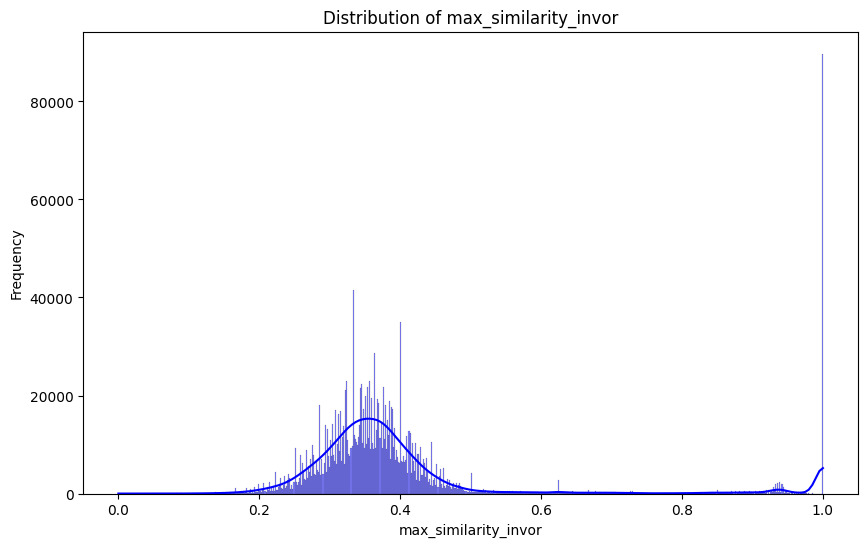

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制直方图
plt.figure(figsize=(10, 6))
sns.histplot(final_df['max_similarity_invor'], kde=True, color='blue')  # KDE曲线用于估计概率密度函数
plt.title('Distribution of max_similarity_invor')
plt.xlabel('max_similarity_invor')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# 计算大于0.80的样本数量
count_above_80 = (final_df['max_similarity_invor'] > 0.80).sum()
# 计算总样本数量
total_samples = final_df.shape[0]
# 计算大于0.80的样本占总样本的百分比
percentage_above_80 = (count_above_80 / total_samples) * 100
# 打印结果
print("Number of samples with 'max_similarity_invor' greater than 0.80:", count_above_80)
print("Percentage of total samples:", percentage_above_80, "%")


Number of samples with 'max_similarity_invor' greater than 0.80: 123095
Percentage of total samples: 7.496125423615277 %


In [ ]:
# Counting samples where 'inventor_name' is missing
missing_inventor_name_count = final_df['inventor_name'].isna().sum()

# Counting samples where 'inventor_name' is an empty string
empty_inventor_name_count = (final_df['inventor_name'] == '').sum()

missing_inventor_name_count, empty_inventor_name_count

(0, 0)

In [ ]:
print(final_df.columns)

Index(['rf_id', 'file_id', 'cname', 'caddress_1', 'caddress_2', 'caddress_3',
       'caddress_4', 'reel_no', 'frame_no', 'convey_text', 'record_dt',
       'last_update_dt', 'page_count', 'purge_in', 'convey_ty',
       'employer_assign', 'or_name', 'exec_dt', 'ack_dt', 'title', 'lang',
       'appno_doc_num', 'appno_date', 'appno_country', 'pgpub_doc_num',
       'pgpub_date', 'pgpub_country', 'grant_doc_num', 'grant_date',
       'grant_country', 'ee_name', 'ee_address_1', 'ee_address_2', 'ee_city',
       'ee_state', 'ee_postcode', 'ee_country', 'index', 'ee_country_full',
       'standard_name_ee', 'asstype_firm_ee', 'asstype_indiv_ee',
       'asstype_government_ee', 'asstype_hosp_ee', 'asstype_university_ee',
       'asstype_institute_ee', 'uspto_StandardName', 'uspto_StemName',
       'index_eeFirm', 'inventor_name', 'standard_inventor_name',
       'standard_or_name', 'max_similarity_invor', 'max_inventor'],
      dtype='object')
